# Predicción de pedidos cancelados vs entregados

Para este Notebook, daremos respuesta a la pregunta: ¿Podemos predecir qué pedidos serán cancelados antes de procesarlos?, con lo cual, vamos a construir diferentes modelos de clasificación y ver cual de ellos funciona mejor.

In [2]:
# Importación del datos y análisis exploratorio inicial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('../Data/Amazon.csv')
df

,OrderID,OrderDate,CustomerID,CustomerName,ProductID,ProductName,Category,Brand,Quantity,UnitPrice,Discount,Tax,ShippingCost,TotalAmount,PaymentMethod,OrderStatus,City,State,Country,SellerID
0,ORD0000001,2023-01-31,CUST001504,Vihaan Sharma,P00014,Drone Mini,Books,BrightLux,3,106.59,0.00,0.00,0.09,319.86,Debit Card,Delivered,Washington,DC,India,SELL01967
1,ORD0000002,2023-12-30,CUST000178,Pooja Kumar,P00040,Microphone,Home & Kitchen,UrbanStyle,1,251.37,0.05,19.10,1.74,259.64,Amazon Pay,Delivered,Fort Worth,TX,United States,SELL01298
2,ORD0000003,2022-05-10,CUST047516,Sneha Singh,P00044,Power Bank 20000mAh,Clothing,UrbanStyle,3,35.03,0.10,7.57,5.91,108.06,Debit Card,Delivered,Austin,TX,United States,SELL00908
3,ORD0000004,2023-07-18,CUST030059,Vihaan Reddy,P00041,Webcam Full HD,Home & Kitchen,Zenith,5,33.58,0.15,11.42,5.53,159.66,Cash on Delivery,Delivered,Charlotte,NC,India,SELL01164
4,ORD0000005,2023-02-04,CUST048677,Aditya Kapoor,P00029,T-Shirt,Clothing,KiddoFun,2,515.64,0.25,38.67,9.23,821.36,Credit Card,Cancelled,San Antonio,TX,Canada,SELL01411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,ORD0099996,2023-03-07,CUST001356,Karan Joshi,P00047,Memory Card 128GB,Electronics,Apex,2,492.34,0.00,78.77,2.75,1066.20,UPI,Delivered,Jacksonville,FL,India,SELL00041
99996,ORD0099997,2021-11-24,CUST031254,Sunita Kapoor,P00046,Car Charger,Sports & Outdoors,Apex,5,449.30,0.00,179.72,6.07,2432.29,Credit Card,Delivered,San Jose,CA,United States,SELL01449
99997,ORD0099998,2023-04-29,CUST012579,Aman Gupta,P00030,Dress Shirt,Sports & Outdoors,BrightLux,4,232.40,0.00,74.37,12.43,1016.40,Cash on Delivery,Delivered,Indianapolis,IN,United States,SELL00028
99998,ORD0099999,2021-11-01,CUST026243,Simran Gupta,P00046,Car Charger,Sports & Outdoors,HomeEase,1,294.05,0.00,23.52,13.09,330.66,Debit Card,Delivered,Charlotte,NC,United States,SELL00324


Ahora, como primer paso lo que haremos sera seleccionar la variable objetivo, en este caso es la variable "OrderStatus", con lo cual tomaremos los valores de "Cancelled" como 1, ya que representan los datos que necesitariamos analizar al ser pedidos con perdida para la empresa, y los valores de "Delivered" los tomaremos como 0. descartamos los otros valores ya que no nos aportaria mucho al crear el modelo y podria generarnos algun tipo de sesgo, porque al ser datos de pedidos devueltos, enviados y pendientes, no determina con exactitud si el pedido fue cancelado o no.

## Creación y transformación de variables para análisis exploratorio y modelado

creamos las nuevas columnas de "Month" y "Day" a partir de la columna "OrderDate", para hacerles un análisis mas detallado a las fechas de los pedidos. Tambien creamos la columna "TotalAmount" para clasificar los precios de cada producto.

In [4]:
df_analisis = df[~df["OrderStatus"].isin(['Pending', 'Returned', 'Shipped'])].copy()
df_analisis["target"] = np.where(df_analisis["OrderStatus"] == 'Cancelled', 1, 0)

# Creación de la columna 'Month' con nombres
meses = {
    1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio',
    7: 'Julio', 8: 'Agosto', 9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'}
df_analisis['Month'] = pd.to_datetime(df_analisis['OrderDate']).dt.month.map(meses)

# Creación de la columna 'Day' con nombres
dias = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}
df_analisis['Day'] = pd.to_datetime(df_analisis['OrderDate']).dt.dayofweek.map(dias)

# Creación de la columna 'Product_Value' basada en cuantiles de 'UnitPrice' 
df_analisis['Product_Value'] = pd.qcut(df_analisis['UnitPrice'], q=3, labels=['Economico', 'Estandar', 'Premium'])

## Análisis exploratorio de datos (EDA)

Ahora veremos la distribución de la columna "target" que acabamos de crear para ver si hay un balance adecuado entre las clases.

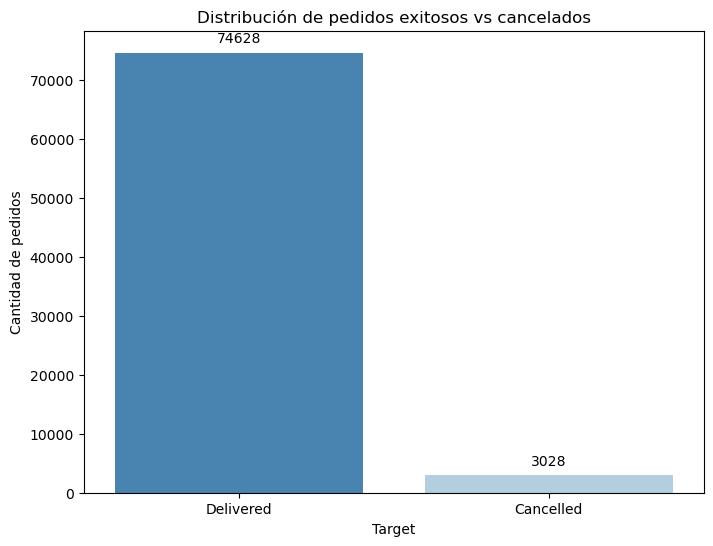

In [7]:
plt.figure(figsize=(8, 6))
g = sns.countplot(data=df_analisis, x='OrderStatus', hue='OrderStatus', palette='Blues_r', legend=False)
for container in g.containers:
    g.bar_label(container, fmt='%d', padding=5, fontsize=10)

plt.xlabel("Target")
plt.ylabel("Cantidad de pedidos")
plt.title("Distribución de pedidos exitosos vs cancelados")
plt.show()

Vemos como hay un claro desbalance entre las clases, con lo cual, al momento de entrenar los modelos, realizaremos tecnicas para balancear los datos. Seguidamente, haremos una exploracion de las variables que mas llamen la atencion y puedan ser utiles para tener una idea de cuales podrian ser las mas relevantes para predecir la variable objetivo y tener las mejores metricas posibles.

A continuación, veremos la distribución de cada pedido cancelado en función de la variable "PaymentMethod", para ver si hay alguna diferencia entre la distribucion de los pedidos cancelados y los que no.

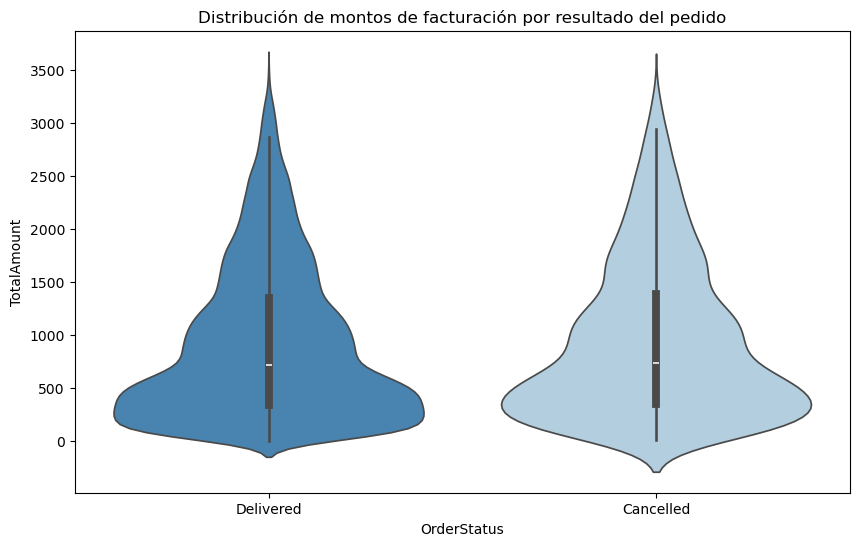

,TotalAmount,Quantity
OrderStatus,,
Cancelled,941.585994,3.052180
Delivered,916.179947,2.998325


In [6]:
analisis_estados = df_analisis.groupby('OrderStatus')[['TotalAmount', 'Quantity']].mean()

plt.figure(figsize=(10,6))
sns.violinplot(data=df_analisis, x='OrderStatus', y='TotalAmount', hue ='OrderStatus', palette='Blues_r')
plt.title('Distribución de montos de facturación por resultado del pedido')
plt.show()

analisis_estados

Notamos que a pesar de que la mayoria de pedidos son exitosos, tienen la misma distribucion con los cancelados, con lo cual esta variable no nos aporta mucha informacion relevante.

Ahora, procederemos a ver el ratio de diferentes variables para ver si las variables nos aportan informacion relevante de saber el porque un pedido puede ser cancelado y tambien saber en que variables es donde hay mas perdida para la empresa.

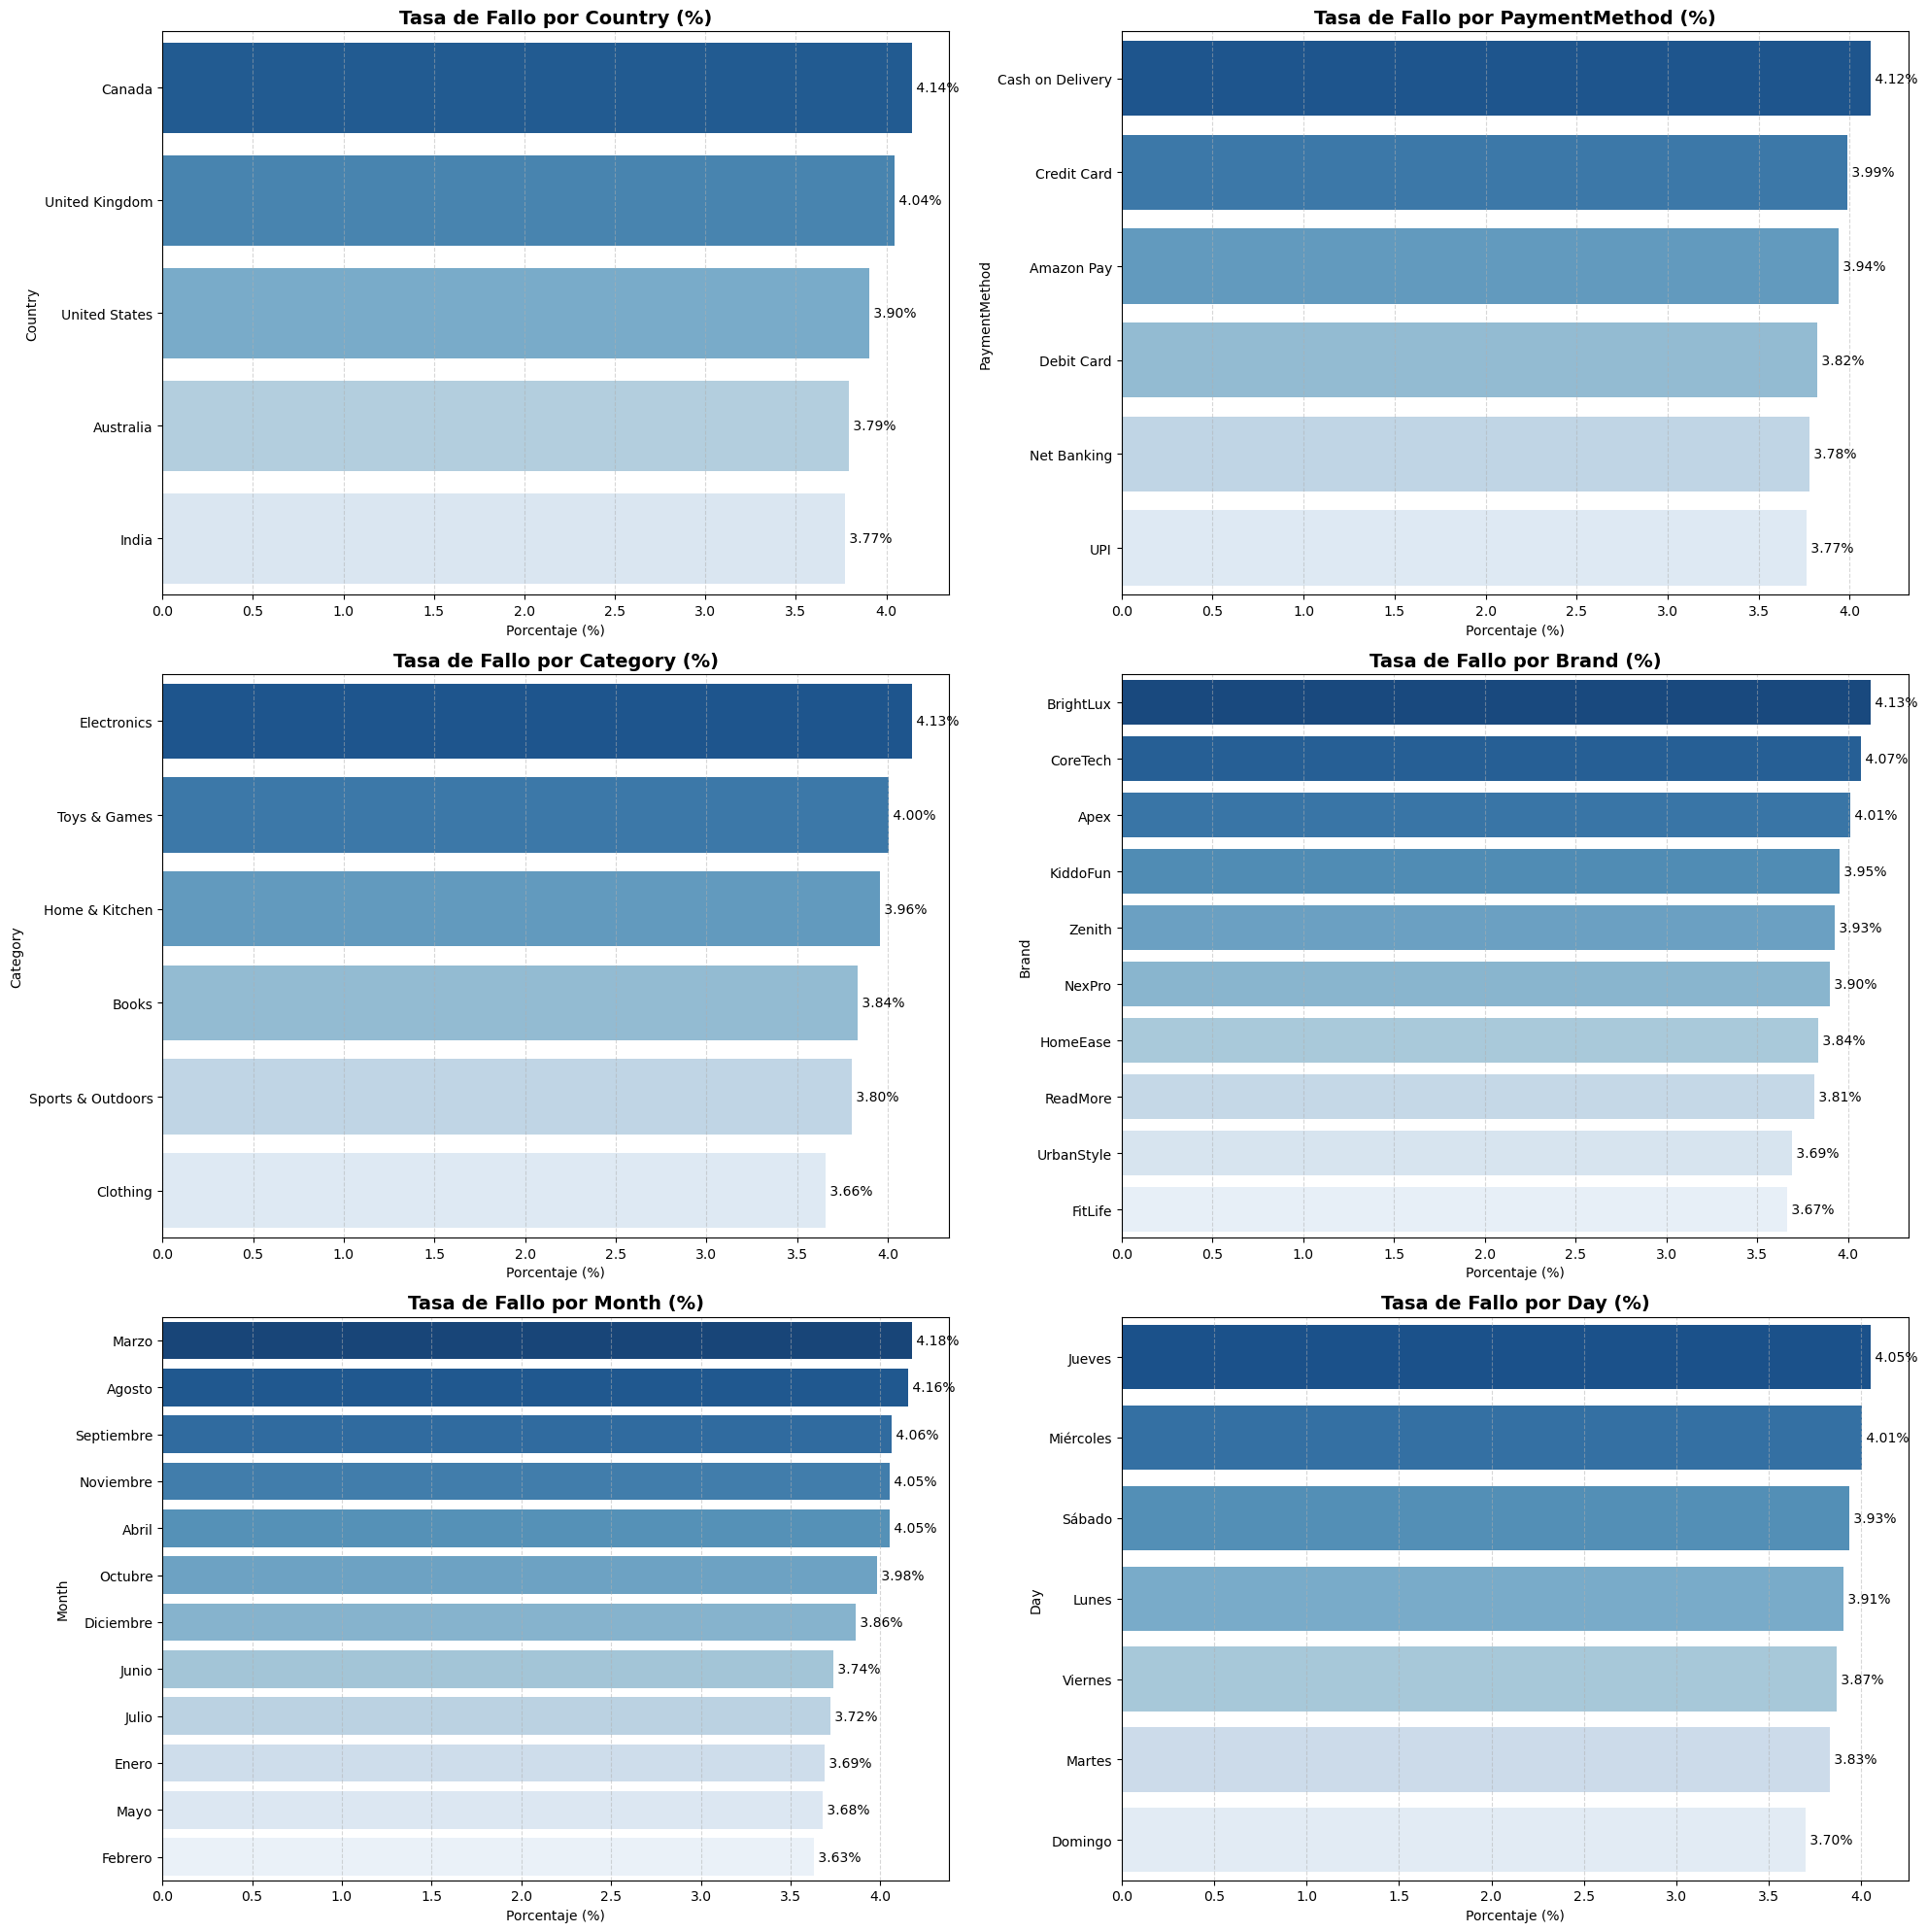

In [12]:
features = ["Country", "PaymentMethod", "Category", "Brand", "Month", "Day"]

fig, axs = plt.subplots(3, 2, figsize=(20, 20))
axs = axs.flatten()

for i, col in enumerate(features):
    ratio_df = df_analisis.groupby(col)['target'].agg(['count', 'sum']).reset_index()
    ratio_df.columns = [col, 'Total', 'Fallos']
    ratio_df['Rate'] = (ratio_df['Fallos'] / ratio_df['Total']) * 100
    ratio_df = ratio_df.sort_values(by='Rate', ascending=False)

    sns.barplot(data=ratio_df, x='Rate', y=col, ax=axs[i], palette='Blues_r', hue=col, legend=False)
    for index, value in enumerate(ratio_df['Rate']):
        axs[i].text(value, index, f' {value:.2f}%', va='center', fontsize=10)

    axs[i].set_title(f'Tasa de Fallo por {col} (%)', fontsize=14, fontweight='bold')
    axs[i].set_xlabel('Porcentaje (%)')
    axs[i].set_ylabel(col)
    axs[i].grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()